# Parking in Seattle

Driving in Seattle is quickly becoming very similar to driving in cities like San Francisco, Silicon Valley or Los Angeles: more and more companies choose to settle or open their offices in Seattle so they can tap into the tech community that Seattle has to offer. With that, parking in Seattle is getting harder by day.

Paid Parking Occupancy dataset provided by the City of Seattle Department of Transportation provides a view into around 300 million parking transactions annually from around 12 thousands parking spots on roughly 1,500 block faces. The dataset does not include any transaction for Sundays as there is no paid parking. Most of the parking spots have a 2-hour limit.

## Load the modules

First, we'll load the necessary modules and instantiate the `BlazingContext()`.

In [1]:
from blazingsql import BlazingContext

import cudf
import pandas as pd
import json

pd.options.display.max_rows = 100

bc = BlazingContext()

BlazingContext ready


# Register S3 bucket
Next, since we are reading from S3 we need to register the bucket we hold the data in.

In [2]:
_ = bc.s3(
    'bsql'
    , bucket_name = 'bsql'
)

# Create the tables

Now that we registered the S3 bucket we can create our tables. First, specify the locations.

In [3]:
transactions_partitions_cnt = 10
transactions_path = 's3://bsql/data/seattle_parking/parking_MayJun2019.parquet/partition_idx={partition}/'
transactions_parq = [transactions_path.format(partition=p) for p in range(transactions_partitions_cnt)]

locations_parq = 's3://bsql/data/seattle_parking/parking_locations.parquet/'

The table below helps mapping the day-of-the-week to its string representation.

In [4]:
dow = cudf.DataFrame([
          (0, 'Monday')
        , (1, 'Tuesday')
        , (2, 'Wednesday')
        , (3, 'Thursday')
        , (4, 'Friday')
        , (5, 'Saturday')
        , (6, 'Sunday')
    ], columns=['dow', 'dow_str'])

Finally, create the table.

In [5]:
%%time
bc.create_table('parking_transactions', transactions_parq)
bc.create_table('parking_locations', locations_parq)
bc.create_table('dow', dow)

CPU times: user 250 ms, sys: 41.7 ms, total: 291 ms
Wall time: 2.13 s


# Basic information
Let's build some basic understanding of the data we're dealing with.

## Parking transactions
Let's look up the first 10 parking transactions.

In [6]:
%%time
transactions_sample = bc.sql('SELECT * FROM parking_transactions LIMIT 10')

CPU times: user 1.56 s, sys: 59.2 ms, total: 1.62 s
Wall time: 1.3 s


The top 10 transactions are now in the `transactions_sample` cudf DataFrame. 

Let's look at the features of this dataset.

In [10]:
%%time
print(f'The dataset has {bc.sql("SELECT COUNT(*) FROM parking_transactions").to_pandas().values.tolist()[0][0]:,} records and {transactions_sample.shape[1]} columns.')

The dataset has 12,168,760 records and 4 columns.
CPU times: user 642 ms, sys: 99.7 ms, total: 742 ms
Wall time: 665 ms


In [11]:
print(f'List of columns: {", ".join(list(transactions_sample.columns))}.')

List of columns: OccupancyDateTime, PaidOccupancy, SourceElementKey, dow.


In [12]:
transactions_sample.dtypes

OccupancyDateTime    datetime64[ms]
PaidOccupancy                 int64
SourceElementKey              int64
dow                            int8
dtype: object

Most of the columns are self-explanatory: 

1. `OccupancyDateTime` describes when the transaction took place.
2. `PaidOccupancy` indicated the total number of spots occupied at that point in time.
3. `SourceElementKey` is the ID of the parking spot.
4. `dow` is the integer representation of the day-of-week (0 = Monday).

Here's the sample rows.

In [14]:
transactions_sample

,OccupancyDateTime,PaidOccupancy,SourceElementKey,dow
0,2019-05-24 08:35:00,1,35438,4
1,2019-05-24 13:41:00,3,58402,4
2,2019-05-24 09:29:00,3,59954,4
3,2019-05-24 08:32:00,1,76961,4
4,2019-05-24 15:17:00,1,32466,4
5,2019-05-24 12:28:00,4,68921,4
6,2019-06-10 13:40:00,4,75169,0
7,2019-06-10 09:33:00,4,36118,0
8,2019-06-10 19:13:00,4,7265,0
9,2019-06-10 08:28:00,2,79789,0


## Parking locations
The next table holds the list of all the transactions with their metadata.

In [15]:
%%time
locations_sample = bc.sql('SELECT * FROM parking_locations LIMIT 10')

CPU times: user 52.4 ms, sys: 7.38 ms, total: 59.8 ms
Wall time: 139 ms


Let's look at the metadata here.

In [17]:
print(f'The dataset has {bc.sql("SELECT COUNT(*) FROM parking_locations").to_pandas().values.tolist()[0][0]:,} records and {locations_sample.shape[1]} columns.')

The dataset has 1,528 records and 9 columns.


In [18]:
print(f'List of columns: {", ".join(list(locations_sample.columns))}.')

List of columns: SourceElementKey, BlockfaceName, SideOfStreet, ParkingTimeLimitCategory, ParkingSpaceCount, PaidParkingArea, PaidParkingSubArea, ParkingCategory, Location.


In [19]:
locations_sample.dtypes

SourceElementKey             int64
BlockfaceName               object
SideOfStreet                object
ParkingTimeLimitCategory     int64
ParkingSpaceCount            int64
PaidParkingArea             object
PaidParkingSubArea          object
ParkingCategory             object
Location                    object
dtype: object

We have 9 columns:

1. `SourceElementKey` is the ID of the parking spot. We will use it to join with the `parking_transactions` table
2. `BlockfaceName` describes the location of the parking spot in terms of blocks (see below for an example)
3. `SideOfStreet` indicates whether the parking is on the e.g. north or south side for a street that runs from east to west
4. `ParkingTimeLimitCategory` shows the maximum allowed parking time (in minutes) at the location
5. `ParkingSpaceCount` gives the total number of parking spots available at the location
6. `PaidParkingArea` describes the broader parking area name
7. `PaidParkingSubArea` can be better understood as a city-quarter (e.g. Belltown, or Pioneer Square)
8. `ParkingCategory` indicates either a Carpool Parking, Paid Parking or RPZ (Restricted Parking Zone)
9. `Location` a point location in a WKT (Well Known Text) format (see an example below).

In [20]:
locations_sample

,SourceElementKey,BlockfaceName,SideOfStreet,ParkingTimeLimitCategory,ParkingSpaceCount,PaidParkingArea,PaidParkingSubArea,ParkingCategory,Location
0,1009,1ST AVE BETWEEN MADISON ST AND SPRING ST,SW,30,5,Commercial Core,Waterfront,Paid Parking,POINT (-122.3366575 47.60501765)
1,1018,1ST AVE BETWEEN STEWART ST AND VIRGINIA ST,NE,120,12,Belltown,South,Paid Parking,POINT (-122.34188878 47.61073498)
2,1045,1ST AVE N BETWEEN REPUBLICAN ST AND MERCER ST,W,120,11,Uptown,Core,Paid Parking,POINT (-122.35549857 47.62391565)
3,1213,1ST AVE S BETWEEN YESLER WAY AND S WASHINGTON ST,W,120,11,Pioneer Square,Core,Paid Parking,POINT (-122.33428548 47.60129336)
4,1214,1ST AVE S BETWEEN YESLER WAY AND S WASHINGTON ST,E,120,11,Pioneer Square,Core,Paid Parking,POINT (-122.3340747 47.60129576)
5,1218,1ST AVE S BETWEEN S WASHINGTON ST AND S MAIN ST,E,120,9,Pioneer Square,Core,Paid Parking,POINT (-122.33407785 47.60046351)
6,1222,1ST AVE S BETWEEN RAILROAD N WAY S AND RAILROA...,E,120,6,Pioneer Square,Edge,Paid Parking,POINT (-122.33405747 47.59609416)
7,1233,10TH AVE BETWEEN E PIKE ST AND E PINE ST,W,120,9,Pike-Pine,UKN,Paid Parking,POINT (-122.31955777 47.61468219)
8,1234,10TH AVE BETWEEN E PIKE ST AND E PINE ST,E,120,27,Pike-Pine,UKN,Paid Parking,POINT (-122.31934691 47.614681)
9,1281,1ST AVE W BETWEEN W MERCER ST AND W ROY ST,W,240,5,Uptown,Edge,Paid Parking,POINT (-122.35809341 47.62515306)


Clean up some duplicates

In [21]:
bc.create_table('parking_locations', bc.sql('SELECT * FROM parking_locations').drop_duplicates(subset=['SourceElementKey']))

# Featurize parking transactions
Since we'll be looking at the parking occupancy per hour of the day, per day of the week, let's extract the date features.

In [22]:
bc.create_table('parking_transactions'
    , bc.sql('''
        SELECT *
            , YEAR(OccupancyDateTime) AS o_year 
            , MONTH(OccupancyDateTime) AS o_month
            , DAYOFMONTH(OccupancyDateTime) AS o_day
            , HOUR(OccupancyDateTime) AS o_hour
        FROM parking_transactions
    ''')
)
bc.sql('SELECT * FROM parking_transactions LIMIT 10')

,OccupancyDateTime,PaidOccupancy,SourceElementKey,dow,o_year,o_month,o_day,o_hour
0,2019-05-24 08:35:00,1,35438,4,2019,5,24,8
1,2019-05-24 13:41:00,3,58402,4,2019,5,24,13
2,2019-05-24 09:29:00,3,59954,4,2019,5,24,9
3,2019-05-24 08:32:00,1,76961,4,2019,5,24,8
4,2019-05-24 15:17:00,1,32466,4,2019,5,24,15
5,2019-05-24 12:28:00,4,68921,4,2019,5,24,12
6,2019-06-10 13:40:00,4,75169,0,2019,6,10,13
7,2019-06-10 09:33:00,4,36118,0,2019,6,10,9
8,2019-06-10 19:13:00,4,7265,0,2019,6,10,19
9,2019-06-10 08:28:00,2,79789,0,2019,6,10,8


Let's see how many transactions we get per day.

CPU times: user 1.55 s, sys: 35.4 ms, total: 1.59 s
Wall time: 1.23 s


<AxesSubplot:xlabel='o_year,o_month,o_day'>

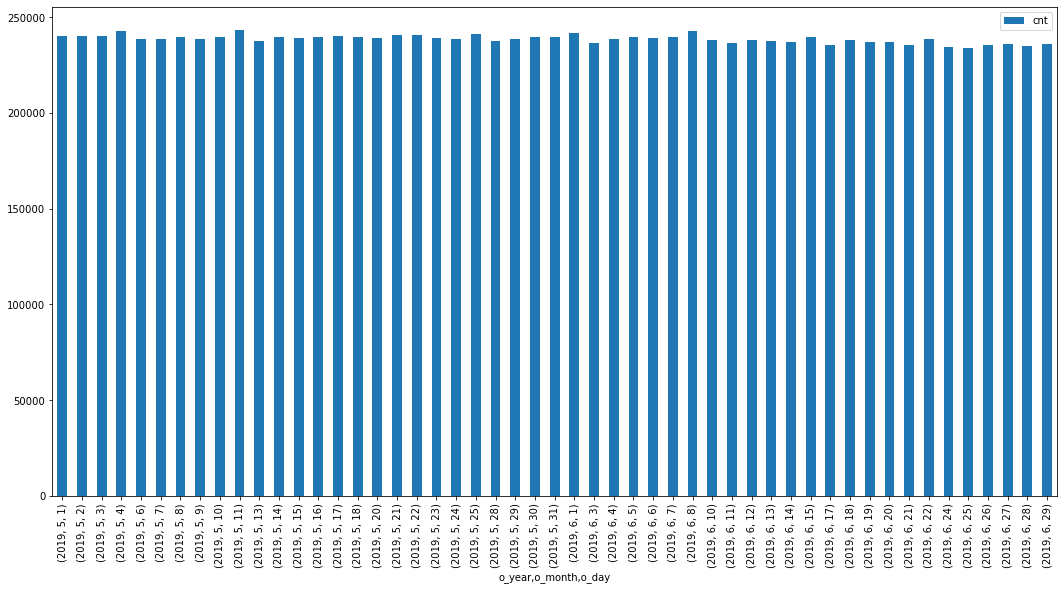

In [23]:
%%time
counts = bc.sql('''
    SELECT o_year
        , o_month
        , o_day
        , COUNT(*) AS cnt
    FROM parking_transactions
    GROUP BY o_year
        , o_month
        , o_day
    ORDER BY o_year
        , o_month
        , o_day
''')
counts.to_pandas().set_index(['o_year', 'o_month', 'o_day']).plot(kind='bar', figsize=(18,9))

As you can see we get almost consistently the same daily number of transactions.

In [24]:
print('Average number of transactions per day: {0:,.0f}'.format(counts['cnt'].mean()))

Average number of transactions per day: 238,603


# Featurize parking locations
Let's now extract the latitude and longitude from the parking `Location` metadata.

In [25]:
bc.create_table('parking_locations', 
    bc.sql('''
        SELECT *
            , CAST(SUBSTRING(Location, 8, delimiter_location - 10) AS FLOAT) AS LON
            , SUBSTRING(Location, delimiter_location, A.len - delimiter_location) AS LAT
        FROM (
            SELECT *
                , CHAR_LENGTH(Location) AS len
                , CASE 
                    WHEN SUBSTRING(Location, 19, 1) = ' ' THEN 20 
                    WHEN SUBSTRING(Location, 20, 1) = ' ' THEN 21 
                    WHEN SUBSTRING(Location, 21, 1) = ' ' THEN 22
                    WHEN SUBSTRING(Location, 22, 1) = ' ' THEN 23
                  END AS delimiter_location
            FROM parking_locations 
        ) AS A
    ''')
)

# Average occupancy
Average occupancy can be higher than 100%: I think it's a data fluke. Thus, we cap it at 100% in the query below.

In [26]:
%%time
bc.create_table('parking_transactions'
    , bc.sql('''
        SELECT SourceElementKey
            , OccupancyDateTime
            , PaidOccupancy
            , ParkingSpaceCount
            , CASE WHEN AvgOccupancy > 1 THEN 1 ELSE AvgOccupancy END AS AvgOccupancy
            , dow
            , o_hour
        FROM (
            SELECT A.*
                , B.ParkingSpaceCount
                , A.PaidOccupancy / CAST(B.ParkingSpaceCount AS FLOAT) AS AvgOccupancy
            FROM parking_transactions AS A
            LEFT OUTER JOIN (SELECT SourceElementKey, ParkingSpaceCount FROM parking_locations) AS B
                ON A.SourceElementKey = B.SourceElementKey
        ) AS inner_table
    ''')
)

bc.sql('SELECT * FROM parking_transactions LIMIT 10')

CPU times: user 155 ms, sys: 73.6 ms, total: 229 ms
Wall time: 158 ms


,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,AvgOccupancy,dow,o_hour
0,58186,2019-06-28 15:07:00,3,8,0.375000,4,15
1,34885,2019-06-28 15:38:00,4,15,0.266667,4,15
2,46766,2019-06-28 10:14:00,2,19,0.105263,4,10
3,79022,2019-06-28 11:31:00,7,6,1.000000,4,11
4,35749,2019-06-28 12:56:00,2,7,0.285714,4,12
5,75282,2019-06-28 08:51:00,3,5,0.600000,4,8
6,19486,2019-06-28 18:45:00,1,4,0.250000,4,18
7,9678,2019-06-28 12:36:00,2,5,0.400000,4,12
8,14673,2019-06-28 17:36:00,3,8,0.375000,4,17
9,9357,2019-06-28 16:50:00,1,8,0.125000,4,16


In [27]:
%%time
bc.create_table('means', bc.sql('''
    SELECT SourceElementKey
        , dow
        , o_hour
        , AVG(AvgOccupancy) AS MeanOccupancy
    FROM parking_transactions
    GROUP BY SourceElementKey
        , dow
        , o_hour
'''))

CPU times: user 92.5 ms, sys: 10.9 ms, total: 103 ms
Wall time: 78.7 ms


## Average per day-of-week and per hour

Let's see an average occupancy per day of the week, per hour of the day.

In [28]:
%%time
mean_occupancy = bc.sql('''
    SELECT A.dow
        , B.dow_str
        , A.o_hour
        , AVG(A.AvgOccupancy) AS MeanOccupancy
    FROM parking_transactions AS A
    LEFT OUTER JOIN dow AS B
        ON A.dow = B.dow
    GROUP BY A.dow
        , B.dow_str
        , A.o_hour
    ORDER BY A.dow
        , A.o_hour
''')

CPU times: user 257 ms, sys: 66.7 ms, total: 324 ms
Wall time: 232 ms


<AxesSubplot:xlabel='dow_str,o_hour'>

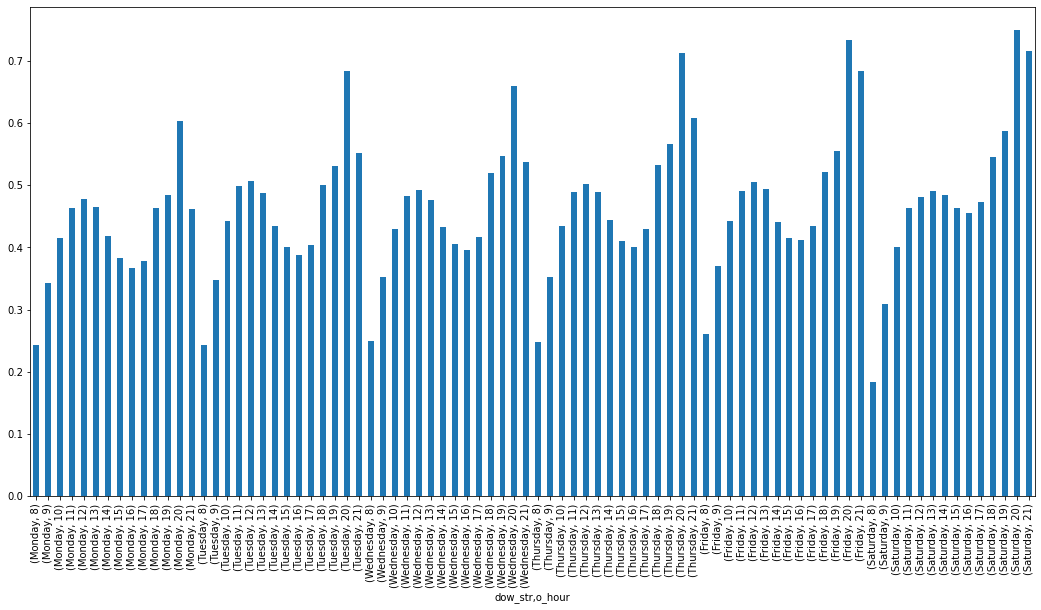

In [29]:
mean_occupancy.to_pandas().set_index(['dow_str', 'o_hour'])['MeanOccupancy'].plot(kind='bar', figsize=(18,9))

You can clearly see the daily seasonality and the effects of the Friday night. **NOTE** Sunday is not present here as the parking in Seattle if free on Sundays.

# Find the best parking
Let's now consider a usecase: you want to come to visit Space Needle in Seattle that has the iconic view of Downtown and of the Puget Sound.

In [30]:
%%time
bc.create_table('parking_locations'
    , bc.sql('''
        SELECT *
            , 47.620422 AS LAT_Ref
            , -122.349358 AS LON_Ref
        FROM parking_locations
    ''')
)

bc.sql('SELECT * FROM parking_locations LIMIT 5')

CPU times: user 59.3 ms, sys: 10.6 ms, total: 69.9 ms
Wall time: 36.1 ms


,SourceElementKey,BlockfaceName,SideOfStreet,ParkingTimeLimitCategory,ParkingSpaceCount,PaidParkingArea,PaidParkingSubArea,ParkingCategory,Location,len,delimiter_location,LON,LAT,LAT_Ref,LON_Ref
0,1001,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,SW,120,4,Pioneer Square,Core,Paid Parking,POINT (-122.33469356 47.6028728),32,22,-122.334694,47.6028728,47.620422,-122.349358
1,1002,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,NE,120,8,Pioneer Square,Core,Paid Parking,POINT (-122.33451266 47.60294861),33,22,-122.334511,47.60294861,47.620422,-122.349358
2,1006,1ST AVE BETWEEN COLUMBIA ST AND MARION ST,NE,120,7,Commercial Core,Waterfront,Paid Parking,POINT (-122.33514326 47.60367439),33,22,-122.335144,47.60367439,47.620422,-122.349358
3,1009,1ST AVE BETWEEN MADISON ST AND SPRING ST,SW,30,5,Commercial Core,Waterfront,Paid Parking,POINT (-122.3366575 47.60501765),32,21,-122.336655,47.60501765,47.620422,-122.349358
4,1010,1ST AVE BETWEEN MADISON ST AND SPRING ST,NE,120,5,Commercial Core,Waterfront,Paid Parking,POINT (-122.33644748 47.6051007),32,22,-122.336449,47.6051007,47.620422,-122.349358


First, we'll calculate a haversine distance from the Kerry Park to each and every parking location in our dataset.

In [31]:
bc.create_table('temp', bc.sql('''
    SELECT SourceElementKey
        , LON
        , LAT
        , LON_Ref
        , LAT_Ref
        , LAT / 180.0 * 3.141592653589 AS LAT_RAD
        , LAT_Ref / 180.0 * 3.141592653589 AS LAT_REF_RAD
        , (LON_Ref - LON) / 180.0 * 3.141592653589 AS DELTA_LON
        , (LAT_Ref - LAT) / 180.0 * 3.141592653589 AS DELTA_LAT
    FROM parking_locations
'''))

bc.create_table('temp', bc.sql('''
        SELECT *
            , POWER(SIN(DELTA_LAT / 2.0),2) + COS(LAT_RAD) * COS(LAT_REF_RAD) * POWER(SIN(DELTA_LON / 2.0),2) AS A
        FROM temp
    ''')
)

bc.create_table('parking_locations', 
    bc.sql('''
        SELECT A.*
            , ASIN(SQRT(A)) * 2 * 3958.8 * 5280 AS DISTANCE_FEET
        FROM parking_locations AS A
        LEFT OUTER JOIN temp AS B
            ON A.SourceElementKey = B.SourceElementKey
    ''')
)

In [32]:
bc.drop_table('temp')

Further, let's now consider that you want to come to visit on Thursday around 5PM. Here's a list of the parking spots that are nearest to Kerry Park and give you the highest chances of actually finding a parking spot.

In [33]:
%%time
day_of_week = 4
hour_of_day = 17

bc.sql(f'''
    SELECT BlockfaceName
        , PaidParkingArea
        , ParkingCategory
        , {day_of_week} AS day_of_week
        , {hour_of_day} AS hour_of_day
        , LON
        , LAT
        , DISTANCE_FEET
        , B.MeanOccupancy
    FROM parking_locations AS A
    LEFT OUTER JOIN means AS B
        ON A.SourceElementKey = B.SourceElementKey
            AND B.dow = {day_of_week}
            AND B.o_hour = {hour_of_day}
    WHERE DISTANCE_FEET < 1000
        AND B.MeanOccupancy <= 0.5
    ORDER BY DISTANCE_FEET ASC
''')

CPU times: user 178 ms, sys: 4.09 ms, total: 182 ms
Wall time: 122 ms


,BlockfaceName,PaidParkingArea,ParkingCategory,day_of_week,hour_of_day,LON,LAT,DISTANCE_FEET,MeanOccupancy
0,CLAY ST BETWEEN 3RD AVE AND 4TH AVE,Belltown,Paid Parking,4,17,-122.349480,47.61806027,862.118197,0.353383
1,3RD AVE BETWEEN BROAD ST AND DENNY WAY,Belltown,Paid Parking,4,17,-122.351189,47.61837759,871.161670,0.428875
2,2ND AVE N BETWEEN JOHN ST AND THOMAS ST,Uptown,Paid Parking,4,17,-122.352936,47.62036489,880.028866,0.415094
3,CLAY ST BETWEEN 3RD AVE AND 4TH AVE,Belltown,Paid Parking,4,17,-122.349297,47.61799756,884.605478,0.474813
4,3RD AVE BETWEEN CLAY ST AND BROAD ST,Belltown,Paid Parking,4,17,-122.350227,47.61801873,902.440232,0.201681
5,THOMAS ST BETWEEN TAYLOR AVE N AND 6TH AVE N,Uptown Triangle,Paid Parking,4,17,-122.345642,47.62082637,925.573610,0.464097
6,3RD AVE BETWEEN CLAY ST AND BROAD ST,Belltown,Paid Parking,4,17,-122.350372,47.61790727,950.718386,0.283120


So, the nearest two parking spots are mostly located in Belltown: within 1000ft you can find 6 parking spots with quite a few open parking spots (on average).